# IANNWTF - Homework 04
(by Group 17 - Nils Niehaus, Philipp Bauer, Marlon Dammann)

## Required Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tqdm import tqdm # We added tqdm to visualize the progress of our training epochs

The dataset "winequality-red" is downloaded from via this [link](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) and then moved to the same folder as this notebook.

---
## 1 - Dataset
### 1.1 Loading the data
For the start we load the data with pandas and analyse the content.

In [2]:
data_raw = pd.read_csv('./winequality-red.csv',sep=';')
data_raw.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


The length of the entire dataset is a joke in comparison to most datasets, therefore we can use the whole dataset easily here.

In [3]:
print(len(data_raw))

1599


The input dimensionality for the network is of size 11 and contains the following wine-related qualities:

In [4]:
print(list(data_raw.keys())[:-1])

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


This is a classification task where the label is the quality of the wine.
Possible labels here are:

In [5]:
print('Possible labels for classification are:',str(set(list(data_raw['quality']))))

Possible labels for classification are: {3, 4, 5, 6, 7, 8}


### 1.2 Tensorflow dataset and pipeline
Now that we know what we are dealing with, we can load the data into a Tensorflow dataset and then preprocess it.
We will need to split the dataset into training, test and validation and also convert it into a supervised form with a tuple of data and label.  
Additionally we want to normalize the data and to make the label a binary one as given in the task.

In [6]:
data = tf.data.Dataset.from_tensor_slices(data_raw.values)
for element in data.take(1):
    print(element)

tf.Tensor(
[ 7.4     0.7     0.      1.9     0.076  11.     34.      0.9978  3.51
  0.56    9.4     5.    ], shape=(12,), dtype=float64)


We then split the dataset into appropriate 60% training, 20% test and 20% validation.  
For this we shuffle the data and then take slices out of it.

In [7]:
data = data.shuffle(len(data))

In [8]:
def split_dataset(dataset,train_size=0.6,test_size=0.2,valid_size=0.2):
    '''Splits a given dataset into training, test and validation subsets.'''
    train_size = int(len(dataset)*train_size)
    test_size = int(len(dataset)*test_size)
    valid_size = int(len(dataset)*valid_size)
    
    '''Due to integer rounding the size may (only) be less than the dataset'''
    while sum([train_size,test_size,valid_size]) != len(dataset):
        train_size += 1 # Increase train size by one if sum is not equal to length
        
    train = dataset.take(train_size)
    test = dataset.skip(train_size).take(test_size)
    valid = dataset.skip(train_size).skip(test_size)
    
    return train, test, valid

In [9]:
data_train, data_test, data_valid = split_dataset(data)

In [10]:
print('Training dataset is of size: ',len(data_train))
print('Test dataset is of size: ',len(data_test))
print('Validation dataset is of size: ',len(data_valid))

Training dataset is of size:  961
Test dataset is of size:  319
Validation dataset is of size:  319


We calculate the median wine quality and use it to write a function to make the targets binary.

In [11]:
quality_threshold = np.median(data_raw['quality'])
print(quality_threshold)

6.0


In [12]:
def make_binary(target):
    '''Classifies wine with greater or equal to median quality as \"good\" wine, meaning 1=True"'''
    return int(target>=quality_threshold)

Afterwards we write the function to preprocess the dataset into the desired shape and value range.

In [13]:
def preprocess_wine_dataset(data_split):
    '''We split the data into input and label'''
    data_split = data_split.map(lambda data: (data[:-1],data[len(data)-1:]))
    '''We make the targets binary with the defined function'''
    data_split = data_split.map(lambda data, label: (data,make_binary(label)))
    '''We take a batch size of 16 and prefetch 10 elements, shuffle is not necessary since it has been performed before'''
    data_split = data_split.batch(16)
    data_split = data_split.prefetch(10)
    return data_split

In [14]:
data_train = data_train.apply(preprocess_wine_dataset)
data_test = data_test.apply(preprocess_wine_dataset)
data_valid = data_valid.apply(preprocess_wine_dataset)

We then print out the first element in the first batch to check our preprocessing.  
The input data should contain normalized floats of shape (11,) and the output a scalar with a zero or one.  

In [15]:
for element in data_train.take(1):
    print((element[0][0], element[1][0]))

(<tf.Tensor: shape=(11,), dtype=float64, numpy=
array([8.1000e+00, 5.3000e-01, 2.2000e-01, 2.2000e+00, 7.8000e-02,
       3.3000e+01, 8.9000e+01, 9.9678e-01, 3.2600e+00, 4.6000e-01,
       9.6000e+00])>, <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>)


---
## 2 Model
We then define our Layer class and model class by mostly copying the previous exercise.  
We changed the sizes of the model layers to fit the task and to enable dynamic downscaling of our model size for the two hidden layers.

In [16]:
class DenseLayer(tf.keras.layers.Layer):
    '''A fully-connected layer with unit weights and biases plus activation function.'''
    def __init__(self, units=8, activation=tf.nn.sigmoid):
        '''Initializes the Layer with a size and an activation.'''
        super(DenseLayer, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        '''Builds the trainable weights and biases for the Layer'''
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)
    def call(self, inputs):
        '''Applies an input to the layer and returns the output'''
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [17]:
class WineClassifierModel(tf.keras.Model):
    '''Our wine-classifier model with adjustable size.'''
    def __init__(self, size_factor=0.01):
        '''Initializes the model with a given down/upscaling of the standard size from the last task.'''
        
        super(WineClassifierModel, self).__init__()
        
        self.input_layer = DenseLayer(units=11, activation=tf.nn.sigmoid) # The input has 11 dimensions for this task
        self.hidden_layer1 = DenseLayer(units=int(256*size_factor), activation=tf.nn.sigmoid) # We scale the former size by a factor
        self.hidden_layer2 = DenseLayer(units=int(256*size_factor), activation=tf.nn.sigmoid)
        self.output_layer = DenseLayer(units=1, activation=tf.nn.sigmoid) # The output layer now consists of a single unit with sigmoid activation

    def call(self, inputs):
        '''The model\'s call method for forwarding the input through the layers.'''
        x = self.input_layer(inputs)
        x = self.hidden_layer1(x)
        x = self.hidden_layer2(x)
        x = self.output_layer(x)
        return x

### 3 Training
We define the necessary training functions and rewrite parts to make them more suitable for both this task and for our optimization visualization later.

In [18]:
loss_memory = {
    'standard_model' : {'training' : [],'test' : [], 'validation' : []}, 
    'optimized_model' : {'training' : [],'test' : [], 'validation' : []}
}
accuracy_memory = {
    'standard_model' : {'training' : [],'test' : [], 'validation' : []}, 
    'optimized_model' : {'training' : [],'test' : [], 'validation' : []}
}

In [19]:
def get_loss_and_accuracy(model, data_split, loss_function):
    '''Returns the loss and accuracy of the model on a given split of the data.'''
    accuracy_aggregator = []
    loss_aggregator = []
    
    for (input, target) in data_split:
        prediction = model(input)
        sample_loss = loss_function(target, prediction)
        sample_accuracy =  target == np.round(prediction,decimals=0) # Since this is not one-hot encoded, we simply compare target and prediction
        sample_accuracy = np.mean(sample_accuracy)
        loss_aggregator.append(sample_loss.numpy())
        accuracy_aggregator.append(np.mean(sample_accuracy))
        
    loss = tf.reduce_mean(loss_aggregator)
    accuracy = tf.reduce_mean(accuracy_aggregator)
    return loss, accuracy

In [20]:
def performance_test(model, data_split, name, loss_function, model_name, loss_memory, accuracy_memory):
    '''Evaluation of loss and accuracy of a model on a data split.'''
    loss, accuracy = get_loss_and_accuracy(model, data_split, loss_function)
    loss_memory[model_name][name].append(loss.numpy())
    accuracy_memory[model_name][name].append(accuracy.numpy())

In [21]:
def train_step(model, input, target, loss_function, optimizer, model_name, loss_memory, accuracy_memory):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [22]:
def train_model(model, dataset, optimizer, loss_function, num_epochs, model_name, loss_memory, accuracy_memory):
    
    '''Initial performance of the model without training'''
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, name, loss_function, model_name, loss_memory, accuracy_memory)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer, model_name, loss_memory, accuracy_memory)
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, name, loss_function, model_name, loss_memory, accuracy_memory)

In [23]:
def is_chance_level(accuracy,labels):
    '''Returns true if the accuracy has been almost chance level for n labels with an allowed variance of 5%'''
    return abs(accuracy-1/labels) <= 0.05

In [24]:
def find_standard_model(dataset, size_factor, num_epochs, loss_function, optimizer, loss_memory, accuracy_memory, model_name='standard_model'):
    standard_model = WineClassifierModel(size_factor=size_factor)
    train_model(standard_model, dataset, optimizer, loss_function, num_epochs, model_name, loss_memory, accuracy_memory)
    '''If the model is within chance level for the validation set, make the model bigger'''
    if is_chance_level(float(accuracy_memory[model_name]['training'][len(accuracy_memory[model_name]['validation'])-1]),2):
        size_factor += size_factor_increment
        print(float(accuracy_memory[model_name]['training'][len(accuracy_memory[model_name]['validation'])-1]))
        loss_memory['standard_model'] = {'training' : [],'test' : [], 'validation' : []}
        accuracy_memory['standard_model'] = {'training' : [],'test' : [], 'validation' : []}
        return find_standard_model(dataset, size_factor, num_epochs, loss_function, optimizer, loss_memory, accuracy_memory, model_name='standard_model')
    else:
        return standard_model, size_factor

In [25]:
tf.keras.backend.clear_session()

'''Hyperparameters'''
num_epochs = 10
learning_rate = 0.001

'''Loss function'''
binary_cross_entropy_loss = tf.keras.losses.BinaryCrossentropy()

'''Optimizer for standard model'''
optimizer = tf.keras.optimizers.SGD(learning_rate)

'''Start with 2% model size (5 layers) and increase by 1% if model is still chance level'''
size_factor = 0.25
size_factor_increment = 0.01

In [26]:
'''Finding the standard model with barely better than chance performance'''
standard_model, size_factor = find_standard_model({'training' : data_train,'test' : data_test,'validation' : data_valid},size_factor,num_epochs,binary_cross_entropy_loss,optimizer, loss_memory, accuracy_memory)

Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 162.46it/s]


0.5409836065573771


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 164.20it/s]


The size of the standard model's two hidden layers has been set to:

In [27]:
print(int(size_factor*256))

66


## 4 Fine-Tuning
Now that we have a standard model with barely above chance performance we want to fine-tune our procedure for a better performance on a same-sized model.  
We start by applying l2 normalization on our data in preprocessing.

In [28]:
def optimized_preprocess_wine_dataset(data_split):
    '''We split the data into input and label'''
    data_split = data_split.map(lambda data: (data[:-1],data[len(data)-1:]))
    '''We make the targets binary with the defined function'''
    data_split = data_split.map(lambda data, label: (data,make_binary(label)))
    '''We normalize the input to a range between 0 and 1 using l2_normalize'''
    data_split = data_split.map(lambda data, label: (tf.math.l2_normalize(data),label))
    '''We take a batch size of 16 and prefetch 10 elements, shuffle is not necessary since it has been performed before'''
    data_split = data_split.batch(16)
    data_split = data_split.prefetch(10)
    return data_split

We implement a condition to stop training if the validation loss has significantly increased from the last epoch to this one.

In [40]:
def optimized_train_model(model, dataset, optimizer, loss_function, num_epochs, model_name, loss_memory, accuracy_memory):
    '''ADD DOCSTRING'''
    
    '''Initial performance of the model without training'''
    for data, name in zip(list(dataset.values()),list(dataset.keys())):
        performance_test(model, data, name, loss_function, model_name, loss_memory, accuracy_memory)
    
    for epoch in range(num_epochs):
        for input,target in tqdm(dataset['training'],desc='Epoch '+str(epoch+1)):
            train_step(model, input, target, loss_function, optimizer, model_name, loss_memory, accuracy_memory)
        for data, name in zip(list(dataset.values()),list(dataset.keys())):
            performance_test(model, data, name, loss_function, model_name, loss_memory, accuracy_memory)
        
        last_valid_loss = loss_memory[model_name]['validation'][len(loss_memory[model_name]['validation'])-2:]
        if last_valid_loss[0] - last_valid_loss[1] < -0.002:
            return

We preprocess our dataset with l2-normalization.

In [41]:
data_train, data_test, data_valid = split_dataset(data)

data_train = data_train.apply(optimized_preprocess_wine_dataset)
data_test = data_test.apply(optimized_preprocess_wine_dataset)
data_valid = data_valid.apply(optimized_preprocess_wine_dataset)

We use Adam as an optimizer and define our optimized model.

In [42]:
optimized_optimizer = tf.keras.optimizers.Adam(learning_rate)
optimized_model = WineClassifierModel(size_factor=size_factor)

In [43]:
optimized_train_model(optimized_model, {'training' : data_train,'test' : data_test,'validation' : data_valid}, optimized_optimizer, binary_cross_entropy_loss, num_epochs, 'optimized_model', loss_memory, accuracy_memory)

Epoch 4: 100%|████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 140.94it/s]


## 5 Visualization

In [33]:
def plot_model_performance(model_name):
    fig, ax = plt.subplots(1,2,figsize=(15, 4))
    line1, = ax[0].plot(loss_memory[model_name]['training'])
    line2, = ax[0].plot(loss_memory[model_name]['validation'])
    line3, = ax[0].plot(loss_memory[model_name]['test'])
    line4, = ax[1].plot(accuracy_memory[model_name]['training'])
    line5, = ax[1].plot(accuracy_memory[model_name]['validation'])
    line6, = ax[1].plot(accuracy_memory[model_name]['test'])
    ax[0].set_xlabel("Training epoch")
    ax[0].set_ylabel("Loss")
    ax[1].set_xlabel("Training epoch")
    ax[1].set_ylabel("Accuracy")
    ax[0].legend((line1,line2,line3),("training","validation","test"))
    ax[1].legend((line4,line5,line6),("training","validation","test"))
    plt.show()

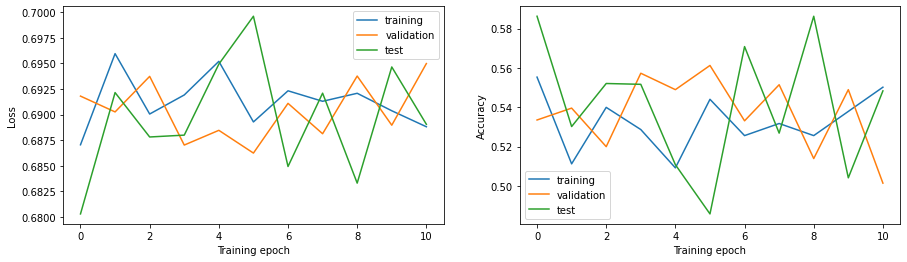

In [34]:
plot_model_performance('standard_model')

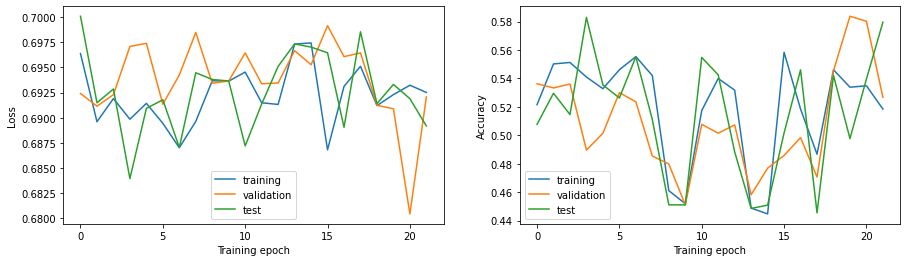

In [44]:
plot_model_performance('optimized_model')

The final accuracy measures on the test data are printed out here:

In [50]:
pd.DataFrame([[accuracy_memory['standard_model']['test'][-1],accuracy_memory['optimized_model']['test'][-1]]],columns=['Standard model','Optimized model'],index=['Final Accuracy'])

,Standard model,Optimized model
Final Accuracy,0.548333,0.579583
